In [135]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt
import statsmodels.formula.api as sm
import warnings 
import itertools

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, auc

In [134]:
# run this if imlearn not installed
# !pip install imblearn

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 8,5

In [4]:
warnings.filterwarnings('ignore')

In [141]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

# Description of Variables

- Age: The age of the employee. (Numerical)
- Attrition: Whether or not the employee has left the organization. (Categorical)
- BusinessTravel: The frequency of business travel for the employee. (Categorical)
- DailyRate: The daily rate of pay for the employee. (Numerical)
- Department: The department the employee works in. (Categorical)
- DistanceFromHome: The distance from home in miles for the employee. (Numerical)
- Education: The level of education achieved by the employee. (Categorical)
- EducationField: The field of study for the employee's education. (Categorical)
- EmployeeCount: The total number of employees in the organization. (Numerical)
- EmployeeNumber: A unique identifier for each employee profile. (Numerical)
- EnvironmentSatisfaction: The employee's satisfaction with their work environment. (Categorical)
- Gender: The gender of the employee. (Categorical)
- HourlyRate: The hourly rate of pay for the employee. (Numerical)
- JobInvolvement: The level of involvement required for the employee's job. (Categorical)
- JobLevel: The job level of the employee. (Categorical)
- JobRole: The role of the employee in the organization. (Categorical)
- JobSatisfaction: The employee's satisfaction with their job. (Categorical)
- MaritalStatus: The marital status of the employee. (Categorical)
- MonthlyIncome: The monthly income of the employee. (Numerical)
- MonthlyRate: The monthly rate of pay for the employee. (Numerical)
- NumCompaniesWorked: The number of companies the employee has worked for. (Numerical)
- Over18: Whether or not the employee is over 18. (Categorical)
- OverTime: Whether or not the employee works overtime. (Categorical)
- PercentSalaryHike: The percentage of salary hike for the employee. (Numerical)
- PerformanceRating: The performance rating of the employee. (Categorical)
- RelationshipSatisfaction: The employee's satisfaction with their relationships. (Categorical)
- StandardHours: The standard hours of work for the employee. (Numerical)
- StockOptionLevel: The stock option level of the employee. (Numerical)
- TotalWorkingYears: The total number of years the employee has worked. (Numerical)
- TrainingTimesLastYear: The number of times the employee was taken for training in the last year. (Numerical)
- WorkLifeBalance: The employee's perception of their work-life balance. (Categorical)
- YearsAtCompany: The number of years the employee has been with the company. (Numerical)
- YearsInCurrentRole: The number of years the employee has been in their current role. (Numerical)
- YearsSinceLastPromotion: The number of years since the employee's last promotion. (Numerical)
- YearsWithCurrManager: The number of years the employee has been with their current manager. (Numerical)

- make people who leave the job 1 (bc there are far less of them)
- min false neg rate to maximizew recall 
- precision recall is a good metric to optimize (most imp recall)
- minimize ppl who will leave

In [10]:
#Load data
df=pd.read_csv("HR_Analytics.csv")
df = pd.get_dummies(df, columns = ["Attrition"])
df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_No,Attrition_Yes
0,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,...,0,8,0,1,6,4,0,5,0,1
1,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,...,1,10,3,3,10,7,1,7,1,0
2,37,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,...,0,7,3,3,0,0,0,0,0,1
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,...,0,8,3,3,8,7,3,0,1,0
4,27,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,...,1,6,3,3,2,2,2,2,1,0


In [11]:
#Keep the dummy column where employees leaving = 1, because there are far less of them and we want to minimize FNR and recall
df = df.drop(["Attrition_No"], axis = 1)

In [12]:
#Splitting up data into train and test data - train has 70% of values and test has 30%
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=25)

print(f"No. of training examples: {train.shape[0]}")
print(f"No. of testing examples: {test.shape[0]}")

No. of training examples: 1029
No. of testing examples: 441


In [13]:
#Printing the ratio of No's and Yes's to the response variable (Attrition) for train and test to make sure they are similar
print(train.Attrition_Yes.value_counts()[1]/train.Attrition_Yes.value_counts()[0])
print(test.Attrition_Yes.value_counts()[1]/test.Attrition_Yes.value_counts()[0])

0.1937354988399072
0.18867924528301888


In [14]:
#Shape of data
print(train.shape)
print(test.shape)

(1029, 35)
(441, 35)


In [16]:
#There are zero missing values that need to be filled in either data set
print(train.isna().sum().sum())
print(test.isna().sum().sum())

0
0


In [13]:
#All column names in dataframe
train.columns

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Attrition_Yes'],
      dtype='object')

In [17]:
#Finding correlations between variables and response
train.corrwith(train.Attrition_Yes).sort_values(ascending = False)

Attrition_Yes               1.000000
DistanceFromHome            0.065658
NumCompaniesWorked          0.029205
MonthlyRate                 0.001126
PerformanceRating          -0.007033
EmployeeNumber             -0.020580
PercentSalaryHike          -0.021023
TrainingTimesLastYear      -0.036240
WorkLifeBalance            -0.039167
Education                  -0.042102
HourlyRate                 -0.044921
YearsSinceLastPromotion    -0.048035
RelationshipSatisfaction   -0.061508
DailyRate                  -0.081930
JobSatisfaction            -0.098817
EnvironmentSatisfaction    -0.113397
JobInvolvement             -0.121431
StockOptionLevel           -0.145659
YearsAtCompany             -0.150960
YearsWithCurrManager       -0.153679
MonthlyIncome              -0.164937
JobLevel                   -0.169904
YearsInCurrentRole         -0.178133
Age                        -0.182642
TotalWorkingYears          -0.185703
EmployeeCount                    NaN
StandardHours                    NaN
d

In [18]:
train.Over18.value_counts()

Y    1029
Name: Over18, dtype: int64

In [19]:
#Drop employee count, over 18 and standard hours because they are the same value for every person
train = train.drop(["EmployeeCount", "StandardHours", "Over18"], axis = 1)
test = test.drop(["EmployeeCount", "StandardHours", "Over18"], axis = 1)
train.columns

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition_Yes'],
      dtype='object')

 OverTime, JobLevel, StockOptionLevel, JobInvolvement, BusinessTravel, NumCompaniesWorked, JobSatisfaction, EnvironmentSatisfaction, EducationField, WorkLifeBalance, Age, DistanceFromHome, YearsSinceLastPromotion, YearsInCurrentRole, YearsAtCompany, TotalWorkingYears, YearsWithCurrManager, Gender, and PercentSalaryHike

In [20]:
interactions = train.loc[:, ['OverTime', 'JobLevel', 'StockOptionLevel', 'JobInvolvement', 'BusinessTravel', 'NumCompaniesWorked', 'JobSatisfaction', 'EnvironmentSatisfaction', 'EducationField', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'YearsSinceLastPromotion', 'YearsInCurrentRole', 'YearsAtCompany', 'TotalWorkingYears', 'YearsWithCurrManager', 'Gender', 'PercentSalaryHike']]

In [21]:
#sns.pairplot(interactions)

In [22]:
#interaction terms: YearsAtCompany*TotalWorkingYears Age*TotalWorkingYears, Age*YearsAtCompany,

In [23]:
interactions.corr()

,JobLevel,StockOptionLevel,JobInvolvement,NumCompaniesWorked,JobSatisfaction,EnvironmentSatisfaction,WorkLifeBalance,Age,DistanceFromHome,YearsSinceLastPromotion,YearsInCurrentRole,YearsAtCompany,TotalWorkingYears,YearsWithCurrManager,PercentSalaryHike
JobLevel,1.000000,0.006959,-0.009112,0.153544,0.021031,0.006035,0.014191,0.511042,0.011966,0.309912,0.365351,0.497739,0.781987,0.336493,-0.008855
StockOptionLevel,0.006959,1.000000,0.067397,0.018944,0.000795,0.022180,0.026797,0.062264,0.048093,0.007439,0.034791,0.020755,0.011130,0.023468,0.007738
JobInvolvement,-0.009112,0.067397,1.000000,0.018458,-0.016585,-0.033744,0.003785,0.051137,0.003617,-0.005133,0.040467,0.006205,0.024000,0.048525,0.037431
NumCompaniesWorked,0.153544,0.018944,0.018458,1.000000,-0.031017,0.026698,-0.004100,0.299410,-0.051574,-0.064959,-0.095547,-0.134277,0.248273,-0.119842,-0.002508
JobSatisfaction,0.021031,0.000795,-0.016585,-0.031017,1.000000,-0.024880,-0.017535,0.031203,-0.027867,-0.001105,0.010160,0.019719,-0.004279,-0.005361,0.028391
EnvironmentSatisfaction,0.006035,0.022180,-0.033744,0.026698,-0.024880,1.000000,0.027154,0.032225,0.011353,0.005821,-0.017946,-0.013449,0.004853,-0.004627,-0.027728
WorkLifeBalance,0.014191,0.026797,0.003785,-0.004100,-0.017535,0.027154,1.000000,-0.022323,-0.022224,0.004330,0.030942,-0.000269,-0.009416,0.008794,-0.006314
Age,0.511042,0.062264,0.051137,0.299410,0.031203,0.032225,-0.022323,1.000000,-0.019316,0.188573,0.213709,0.291780,0.672094,0.195552,0.029420
DistanceFromHome,0.011966,0.048093,0.003617,-0.051574,-0.027867,0.011353,-0.022224,-0.019316,1.000000,0.019615,0.028074,0.023143,0.004865,0.032785,0.068196
YearsSinceLastPromotion,0.309912,0.007439,-0.005133,-0.064959,-0.001105,0.005821,0.004330,0.188573,0.019615,1.000000,0.569019,0.617816,0.379931,0.527536,0.005186


# Visualizations of initial thoughts on variables that could be correlated

In [24]:
# calculate the null count for each column
null_count = df.isnull().sum()
null_count.name = 'count of null' 

# find the datatype for each column
dtype = df.dtypes
dtype.name = 'data type'

# describe the dataframe to get other statistics
data_desc = df.describe(include='all', datetime_is_numeric=True)

# remove count, freq, mean, std, 25%, 50%, and 75% percentiles
data_desc = data_desc.drop(['count', 'freq', 'std', '25%', '75%', 'top'], axis=0)

# transpose the dataframe to prevent the dataframe from being too wide.
data_desc_T = data_desc.T

# add the row of null count and datatype to the dataframe
data_desc_T = pd.concat([dtype, null_count, data_desc_T], axis=1)

# order the summary statistics table by datatype and count of null
data_desc_T = data_desc_T.sort_values(['data type', 'count of null'])

# show the summary statistics table
data_desc_T

,data type,count of null,unique,mean,min,50%,max
Attrition_Yes,uint8,0,NaN,0.161224,0.0,0.0,1.0
Age,int64,0,NaN,36.92381,18.0,36.0,60.0
DailyRate,int64,0,NaN,802.485714,102.0,802.0,1499.0
DistanceFromHome,int64,0,NaN,9.192517,1.0,7.0,29.0
Education,int64,0,NaN,2.912925,1.0,3.0,5.0
EmployeeCount,int64,0,NaN,1.0,1.0,1.0,1.0
EmployeeNumber,int64,0,NaN,1024.865306,1.0,1020.5,2068.0
EnvironmentSatisfaction,int64,0,NaN,2.721769,1.0,3.0,4.0
HourlyRate,int64,0,NaN,65.891156,30.0,66.0,100.0
JobInvolvement,int64,0,NaN,2.729932,1.0,3.0,4.0


In [25]:
df = df.drop(columns = ['Over18','StandardHours','EmployeeCount'])
# We should just drop these columns because they only have 1 unique values and contain no information

<AxesSubplot:>

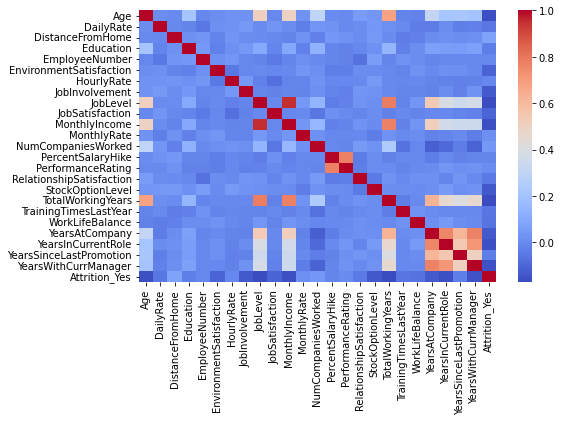

In [26]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')

In [27]:
# count the number of attrition entries
attrition_counts = df['Attrition_Yes'].value_counts()

# calculate the percentage out of total entries
attrition_percent = attrition_counts/attrition_counts.sum()

# make labels for plots
labels = ['Attrition_No-'+str((attrition_percent[0]*100).round(2))+'%', 'Attrition_Yes-'+str((attrition_percent[1]*100).round(2))+'%']

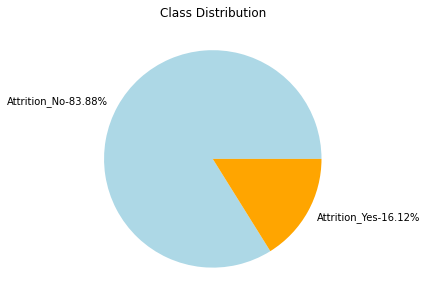

In [28]:
# check for class imbalance of the outcome variable
plt.pie(attrition_counts, labels=labels, colors=['lightblue', 'orange'])
plt.title('Class Distribution')
plt.show()

class imbalance in the outcome variable, maybe do resampling techniques: This involves either oversampling the minority class by duplicating existing examples or undersampling the majority class by reducing the number of examples. Common resampling techniques include random oversampling, random undersampling, and Synthetic Minority Over-sampling Technique (SMOTE). Do this before training the model

<AxesSubplot:xlabel='Attrition_Yes', ylabel='MonthlyIncome'>

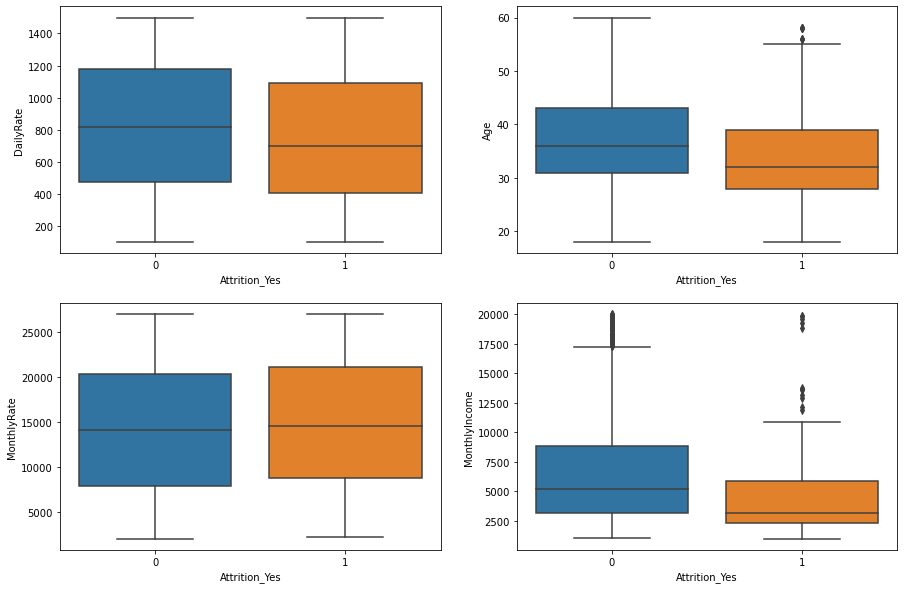

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
sns.boxplot(data=df, x='Attrition_Yes', y='DailyRate', ax=axes[0, 0])
sns.boxplot(data=df, x='Attrition_Yes', y='Age', ax=axes[0, 1])
sns.boxplot(data=df, x='Attrition_Yes', y='MonthlyRate', ax=axes[1, 0])
sns.boxplot(data=df, x='Attrition_Yes', y='MonthlyIncome', ax=axes[1, 1])

In machine learning, having a class imbalance problem can lead to biased models and poor predictive performance. If one class has significantly fewer examples than the other classes, the model may not learn enough from the minority class and may struggle to generalize well to new data.
In our case, having only 16% of Attrition = Yes suggests that our dataset has a significant class imbalance. This can lead to issues such as too many false negatives and reduced model performance overall.
To address this class imbalance problem, we chose to oversample the minority class, as shown in the code below.

In [195]:
# separate the target variable and predictor variables
X = df.drop(columns = ['Attrition_Yes'], axis=1)
y = df['Attrition_Yes']

In [196]:
X = X.rename(columns=lambda x: x.strip())

X = pd.get_dummies(X, drop_first = True)
X.columns = X.columns.str.replace('-', '')
X.columns = X.columns.str.replace(' ', '')
X.columns = X.columns.str.replace('&', '_')

X

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_LaboratoryTechnician,JobRole_Manager,JobRole_ManufacturingDirector,JobRole_ResearchDirector,JobRole_ResearchScientist,JobRole_SalesExecutive,JobRole_SalesRepresentative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1102,1,2,1,2,94,3,2,4,...,0,0,0,0,0,1,0,0,1,1
1,49,279,8,1,2,3,61,2,2,2,...,0,0,0,0,1,0,0,1,0,0
2,37,1373,2,2,4,4,92,2,1,3,...,1,0,0,0,0,0,0,0,1,1
3,33,1392,3,4,5,4,56,3,1,3,...,0,0,0,0,1,0,0,1,0,1
4,27,591,2,1,7,1,40,3,1,2,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,2,2061,3,41,4,2,4,...,1,0,0,0,0,0,0,1,0,0
1466,39,613,6,1,2062,4,42,2,3,1,...,0,0,0,0,0,0,0,1,0,0
1467,27,155,4,3,2064,2,87,4,2,2,...,0,0,1,0,0,0,0,1,0,1
1468,49,1023,2,3,2065,4,63,2,2,2,...,0,0,0,0,0,1,0,1,0,0


In [197]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# perform oversampling on the training data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# print the number of examples in each class before and after oversampling
print("Before oversampling:")
print(y_train.value_counts())
print("After oversampling:")
print(y_train_resampled.value_counts())

Before oversampling:
0    978
1    198
Name: Attrition_Yes, dtype: int64
After oversampling:
0    978
1    978
Name: Attrition_Yes, dtype: int64


In [198]:
y_train_resampled.name = 'Attrition_Yes'

In [199]:
# check for multicolinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data)

                             feature         VIF
0                              const  596.631312
1                                Age    2.193194
2                          DailyRate    1.079127
3                   DistanceFromHome    1.085088
4                          Education    1.131678
5                     EmployeeNumber    1.067639
6            EnvironmentSatisfaction    1.067232
7                         HourlyRate    1.053239
8                     JobInvolvement    1.065647
9                           JobLevel   15.426832
10                   JobSatisfaction    1.072875
11                     MonthlyIncome   18.192908
12                       MonthlyRate    1.096248
13                NumCompaniesWorked    1.339920
14                 PercentSalaryHike    2.590110
15                 PerformanceRating    2.566481
16          RelationshipSatisfaction    1.060952
17                  StockOptionLevel    1.984369
18                 TotalWorkingYears    5.441899
19             Train

In [200]:
# find the columns to drop, i.e. VIF>10
col_to_drop = vif_data.feature[vif_data.VIF>10].to_list()
col_to_drop = col_to_drop[1:]
col_to_drop

['JobLevel',
 'MonthlyIncome',
 'Department_Research_Development',
 'Department_Sales',
 'EducationField_LifeSciences',
 'EducationField_Marketing',
 'EducationField_Medical',
 'JobRole_HumanResources',
 'JobRole_SalesExecutive',
 'JobRole_SalesRepresentative']

In [201]:
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

In [202]:
train = pd.concat([X_train_resampled, pd.DataFrame(y_train_resampled)],axis =1)

In [203]:
column_list = train.columns.to_list()[:-1] #not including Attrition
column_list

['Age',
 'DailyRate',
 'DistanceFromHome',
 'Education',
 'EmployeeNumber',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobSatisfaction',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'BusinessTravel_Travel_Frequently',
 'BusinessTravel_Travel_Rarely',
 'EducationField_Other',
 'EducationField_TechnicalDegree',
 'Gender_Male',
 'JobRole_LaboratoryTechnician',
 'JobRole_Manager',
 'JobRole_ManufacturingDirector',
 'JobRole_ResearchDirector',
 'JobRole_ResearchScientist',
 'MaritalStatus_Married',
 'MaritalStatus_Single',
 'OverTime_Yes']

In [204]:
formula = 'Attrition_Yes~'+'+'.join(column_list)

In [205]:
#logistic regression with all predictors
logit_model = smf.logit(formula=formula, data=train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.446573
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1956
Model:                          Logit   Df Residuals:                     1920
Method:                           MLE   Df Model:                           35
Date:                Fri, 03 Mar 2023   Pseudo R-squ.:                  0.3557
Time:                        19:09:11   Log-Likelihood:                -873.50
converged:                       True   LL-Null:                       -1355.8
Covariance Type:            nonrobust   LLR p-value:                7.893e-180
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            3.0542      0.922      3.313      0.001       1.248       4.861
Age                                 -0.0217      0.009     -2.390      0.017      -0.040      -0.004
DailyRate                           -0.0003      0.000     -1.937      0.053      -0.001    3.61e-06
DistanceFromHome                     0.0339      0.008      4.432      0.000       0.019       0.049
Education                            0.0421      0.060      0.698      0.485      -0.076       0.160
EmployeeNumber                    2.054e-05      0.000      0.198      0.843      -0.000       0.000
EnvironmentSatisfaction             -0.3515      0.058     -6.055      0.000      -0.465      -0.238
HourlyRate                           0.0017      0.003      0.562      0.574      -0.004       0.008
JobInvolvement                      -0.4801      0.088     -5.436      0.000      -0.653      -0.307
JobSatisfaction                     -0.3211      0.057     -5.661      0.000      -0.432      -0.210
MonthlyRate                       1.424e-05   8.64e-06      1.647      0.099    -2.7e-06    3.12e-05
NumCompaniesWorked                   0.1887      0.027      7.081      0.000       0.136       0.241
PercentSalaryHike                   -0.0436      0.026     -1.649      0.099      -0.095       0.008
PerformanceRating                   -0.0770      0.273     -0.283      0.777      -0.611       0.457
RelationshipSatisfaction            -0.0916      0.055     -1.652      0.099      -0.200       0.017
StockOptionLevel                    -0.1709      0.097     -1.769      0.077      -0.360       0.018
TotalWorkingYears                   -0.0995      0.018     -5.576      0.000      -0.134      -0.065
TrainingTimesLastYear               -0.1496      0.048     -3.123      0.002      -0.243      -0.056
WorkLifeBalance                     -0.4158      0.085     -4.899      0.000      -0.582      -0.249
YearsAtCompany                       0.1908      0.024      8.076      0.000       0.145       0.237
YearsInCurrentRole                  -0.2100      0.032     -6.621      0.000      -0.272      -0.148
YearsSinceLastPromotion              0.1243      0.027      4.557      0.000       0.071       0.178
YearsWithCurrManager                -0.1538      0.030     -5.193      0.000      -0.212      -0.096
BusinessTravel_Travel_Frequently     1.9308      0.279      6.923      0.000       1.384       2.477
BusinessTravel_Travel_Rarely         1.2031      0.255      4.712      0.000       0.703       1.704
EducationField_Other                 0.3691      0.251      1.470      0.141      -0.123       0.861
EducationField_TechnicalDegree       1.5111      0.208      7.266      0.000       1.104       1.919
Gender_Male                          0.4359      0.126      3.448      0.001       0.188       0.684
JobRole_LaboratoryTechnician         0.4482      0.161      2.778      0.005       0.132       0.764
JobRole_M

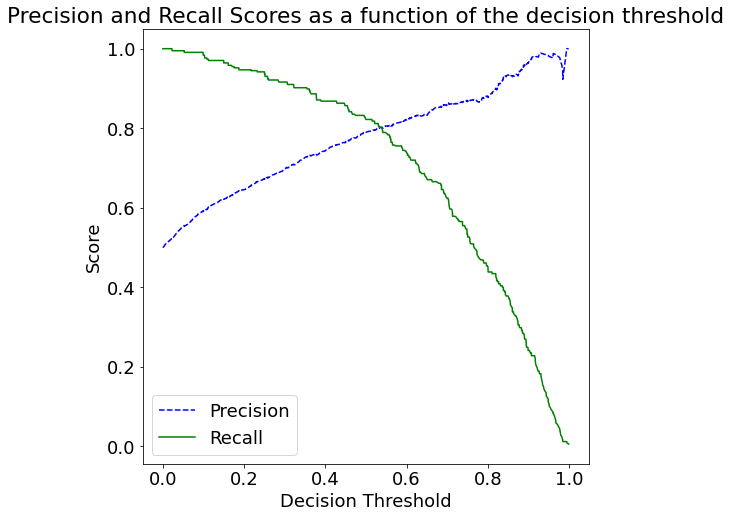

In [230]:
from sklearn.metrics import precision_recall_curve
y=train.Attrition_Yes
ypred = logit_model.predict(train)
p, r, thresholds = precision_recall_curve(y, ypred)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

Classification accuracy = 79.8%
Precision = 80.5%
TPR or Recall = 78.5%
FNR = 21.5%
FPR = 19.0%
ROC-AUC = 87.2%


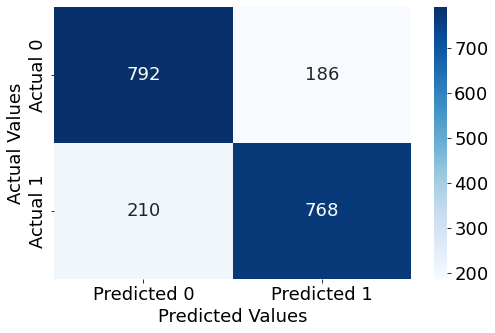

In [235]:
confusion_matrix_data(train,train.Attrition_Yes,logit_model,0.55)

0.8723784192939976


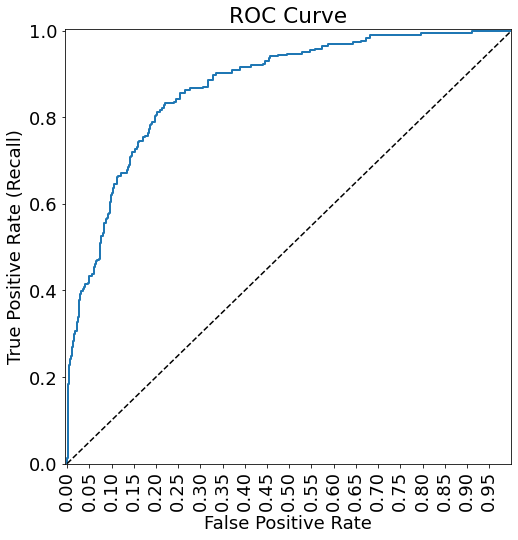

In [232]:
from sklearn.metrics import roc_curve, auc
y=train.Attrition_Yes
ypred = logit_model.predict(train)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

maybe another model with interaction terms and other transformations

In [208]:
#This should be deleted

##Making all predictors dummy variables

#train_num = train.copy()

#diff num for diff job roles, 1 = Human Resources
#X['JobRole'] = X['JobRole'].apply(
   # lambda x: 9 if x=='Sales Executive' else 8 if x == 'Research Scientist' else 7 if x == 'Laboratory Technician' 
   # else 6 if x == 'Manufacturing Director' else 5 if x == 'Healthcare Representative' else 4 if x == 'Manager' 
   # else 3 if x == 'Sales Representative' else 2 if x == 'Research Director' else 1)
#BusinessTravel = 3 if Travel_Frequently, 2 if Travel_Rarely, 1 if no travel
#X['BusinessTravel'] = X['BusinessTravel'].apply(
   #lambda x: 3 if x=='Travel_Frequently' else 2 if x == 'Travel_Rarely' else 1)
# Department = 3 for R&D, 2 for Sales, and 1 for HR
#X['Department'] = X['Department'].apply(
   # lambda x: 3 if x=='Research & Development' else 2 if x == 'Sales' else 1)
# different numbers assigned to every field, 1 = Human Resources
#X['EducationField'] = X['EducationField'].apply(
   # lambda x: 6 if x=='Life Sciences' else 5 if x == 'Medical' else 4 if x == 'Marketing' 
   # else 3 if x == 'Technical Degree' else 2 if x == 'Other' else 1)
# MaritalStatus = 1 if Divorced
#X['MaritalStatus'] = X['MaritalStatus'].apply(
   # lambda x: 3 if x=='Married' else 2 if x == 'Single' else 1)
#X['Gender'] = X['Gender'].apply(lambda x: 1 if x=='Male' else 0)
# OverTime = 1 if Yes, 0 if no
#X['OverTime'] = X['OverTime'].apply(lambda x: 1 if x=='Yes' else 0) #1 if left org

#trying to make train categorical
# diff num for diff job roles, 1 = Human Resources
#train_num['JobRole'] = train_num['JobRole'].apply(
    #lambda x: 9 if x=='Sales Executive' else 8 if x == 'Research Scientist' else 7 if x == 'Laboratory Technician' 
   # else 6 if x == 'Manufacturing Director' else 5 if x == 'Healthcare Representative' else 4 if x == 'Manager' 
   # else 3 if x == 'Sales Representative' else 2 if x == 'Research Director' else 1)
# BusinessTravel = 3 if Travel_Frequently, 2 if Travel_Rarely, 1 if no travel
#train_num['BusinessTravel'] = train_num['BusinessTravel'].apply(
    #lambda x: 3 if x=='Travel_Frequently' else 2 if x == 'Travel_Rarely' else 1)
# Department = 3 for R&D, 2 for Sales, and 1 for HR
#train_num['Department'] = train_num['Department'].apply(
   # lambda x: 3 if x=='Research & Development' else 2 if x == 'Sales' else 1)
# different numbers assigned to every field, 1 = Human Resources
#train_num['EducationField'] = train_num['EducationField'].apply(
   # lambda x: 6 if x=='Life Sciences' else 5 if x == 'Medical' else 4 if x == 'Marketing' 
    #else 3 if x == 'Technical Degree' else 2 if x == 'Other' else 1)
# MaritalStatus = 1 if Divorced
#train_num['MaritalStatus'] = train_num['MaritalStatus'].apply(
    #lambda x: 3 if x=='Married' else 2 if x == 'Single' else 1)
#train_num['Gender'] = train_num['Gender'].apply(lambda x: 1 if x=='Male' else 0)
# OverTime = 1 if Yes, 0 if no
#train_num['OverTime'] = train_num['OverTime'].apply(lambda x: 1 if x=='Yes' else 0) #1 if left org



# Forward selection requires quantitative variables so we have to make the df into dummies


#X2 = pd.get_dummies(X)
#Xcopy = X.copy()
#X = X2.copy()
#X.columns = X.columns.str.replace('-', '')
#X.columns = X.columns.str.replace(' ', '')


#X=X.drop(['BusinessTravel_NonTravel'], axis = 1)
#X['JobRole'] = X['JobRole'].astype('|S')
#X['JobRole'].strip()
#X['JobRole'].str.strip()
#X['JobRole'].dtype
#X['JobRole'] = X['JobRole'].astype(str)
#X['JobRole'].dtype
#train.Attrition_Yes

In [209]:
#Drop correlated variables (VIF > 5)
#Choose between JobLevel, MonthlyIncome, and TotalWorkingYears

In [210]:
#Function to develop a model based on all predictors in predictor_subset
# X = train.drop(["Attrition_Yes",'JobRole','OverTime'], axis = 1)
## X = X.rename(columns=lambda x: x.strip())
## X['JobRole'] = X['JobRole'].astype(str)

train = train.apply(lambda x: x.str.strip() if isinstance(x.iloc[0], str) else x)
def processSubset(predictor_subset):
    if 'Attrition_Yes' in predictor_subset:
        predictor_subset = predictor_subset.remove('Attrition_Yes')

    # Fit model on feature_set and calculate R-squared
    #model = sm.ols('Attrition_Yes~' + '+'.join(predictor_subset),data = train_num).fit()
    #Developing logistic regression model
    logit_model = sm.logit(formula = 'Attrition_Yes~' + '+'.join(predictor_subset),data = train).fit() 
    llf = logit_model.llf
    return {"logit_model":logit_model, "Log-Likelihood":llf}

In [211]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
import time
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train_resampled.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Log-Likelihood'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [212]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Log-Likelihood", "logit_model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X_train_resampled.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["logit_model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

#make dummies for all categorical variables
#change R-squared to log likelihood, keep AIC and BIC
#show all three graphs in
#check for multi-collinearity among all variables first, remove the ones that are colinear (decide which one is most important), then do forward stepwise - use VIF score, (email Krish about what threshold to use, 5 and below you should be good) if they're above the threshold point, remove them
#change predictors to be dummies rather than just dummy variables because forward selection might decide that one of them isn't important and not include them - less of a priority, but if we have time

In [213]:
models_best = forward_selection()

Optimization terminated successfully.
         Current function value: 0.671135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692107
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693004
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692620
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693140
  

Optimization terminated successfully.
         Current function value: 0.602192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601468
         Iterations 5
Processed  33 models on 3 predictors in 0.30881786346435547 seconds.
Optimization terminated successfully.
         Current function value: 0.582126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582870
         Iterations 5
Optimization 

Optimization terminated successfully.
         Current function value: 0.559782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.554990
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.560504
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.561077
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.552998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.558390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.552556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.560716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.558609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.558110
  

Optimization terminated successfully.
         Current function value: 0.533972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.533243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.532613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.535214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.532313
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.536914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.534444
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.536847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.535606
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.534172
  

Optimization terminated successfully.
         Current function value: 0.515952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.513262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.513684
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510842
         Iterations 6
Processed  24 models on 12 predictors in 0.3538999557495117 seconds.
Optimization terminated successfully.
         Current function value: 0.508366
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509695
         Iterations 6
Optimization 

Optimization terminated successfully.
         Current function value: 0.479869
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478399
         Iterations 6
Processed  20 models on 16 predictors in 0.345134973526001 seconds.
Optimization terminated successfully.
         Current function value: 0.476749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477457
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475991
         Iterations 6
Optimization t

Optimization terminated successfully.
         Current function value: 0.460065
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.460561
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461166
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.460523
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.458879
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.460965
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.459235
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461175
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.460102
         Iterations 7
Processed  15 models on 21 predictors in 0.30037522315979004 seconds.
Optimization

Optimization terminated successfully.
         Current function value: 0.449094
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448759
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449012
         Iterations 7
Processed  8 models on 28 predictors in 0.20662999153137207 seconds.
Optimization terminated successfully.
         Current function value: 0.448559
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448710
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448179
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448038
         Iterations 7
Optimization 

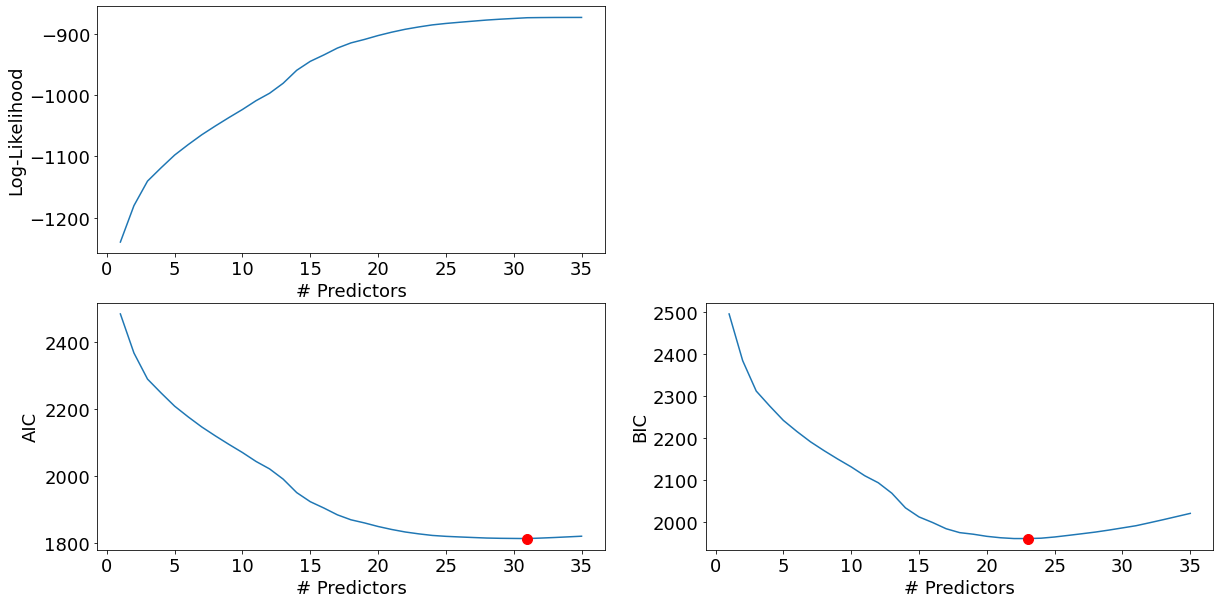

In [214]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Log-Likelihood"])
    plt.xlabel('# Predictors')
    plt.ylabel('Log-Likelihood')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    """
    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('psuedo rsquared')
    """

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [223]:
best_fwd_reg_model = models_best['logit_model'][23]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1956
Model:                          Logit   Df Residuals:                     1932
Method:                           MLE   Df Model:                           23
Date:                Fri, 03 Mar 2023   Pseudo R-squ.:                  0.3443
Time:                        19:10:16   Log-Likelihood:                -889.00
converged:                       True   LL-Null:                       -1355.8
Covariance Type:            nonrobust   LLR p-value:                1.713e-182
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            2.1400      0.590      3.624      0.000       0.983       3.297
OverTime_Yes                         1.9849      0.131     15.109      0.000       1.727       2.242
MaritalStatus_Single                 1.8570      0.179     10.397      0.000       1.507       2.207
TotalWorkingYears                   -0.1277      0.015     -8.497      0.000      -0.157      -0.098
NumCompaniesWorked                   0.1732      0.026      6.677      0.000       0.122       0.224
JobInvolvement                      -0.4982      0.086     -5.785      0.000      -0.667      -0.329
JobRole_LaboratoryTechnician         0.5210      0.155      3.369      0.001       0.218       0.824
EducationField_TechnicalDegree       1.4311      0.202      7.094      0.000       1.036       1.827
BusinessTravel_Travel_Frequently     1.9436      0.273      7.124      0.000       1.409       2.478
JobSatisfaction                     -0.3323      0.055     -6.068      0.000      -0.440      -0.225
WorkLifeBalance                     -0.4120      0.083     -4.993      0.000      -0.574      -0.250
EnvironmentSatisfaction             -0.3340      0.056     -5.970      0.000      -0.444      -0.224
YearsSinceLastPromotion              0.1311      0.026      4.996      0.000       0.080       0.182
YearsInCurrentRole                  -0.1981      0.031     -6.480      0.000      -0.258      -0.138
YearsAtCompany                       0.1889      0.023      8.254      0.000       0.144       0.234
YearsWithCurrManager                -0.1596      0.029     -5.531      0.000      -0.216      -0.103
DistanceFromHome                     0.0359      0.007      4.793      0.000       0.021       0.051
BusinessTravel_Travel_Rarely         1.1982      0.250      4.788      0.000       0.708       1.689
MaritalStatus_Married                0.6988      0.170      4.115      0.000       0.366       1.032
JobRole_ResearchScientist           -0.6269      0.161     -3.891      0.000      -0.943      -0.311
JobRole_ResearchDirector            -1.4835      0.451     -3.289      0.001      -2.368      -0.599
TrainingTimesLastYear               -0.1614      0.047     -3.422      0.001      -0.254      -0.069
Gender_Male                          0.3871      0.124      3.123      0.002       0.144       0.630
PercentSalaryHike                   -0.0466      0.017     -2.753      0.006      -0.080      -0.013
====================================================================================================
"""

Classification accuracy = 79.2%
Precision = 79.7%
TPR or Recall = 78.5%
FNR = 21.5%
FPR = 20.0%
ROC-AUC = 86.6%


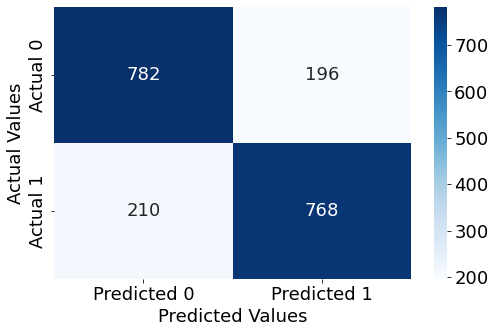

In [237]:
confusion_matrix_data(train,train.Attrition_Yes,best_fwd_reg_model,0.55)

In [ ]:
# confusion_matrix_test(test,test.Attrition_Yes,best_fwd_reg_model,0.55)

0.8663239531450605


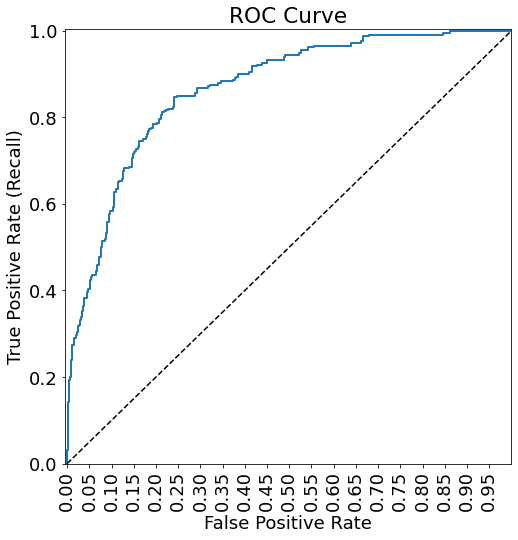

In [238]:
from sklearn.metrics import roc_curve, auc
y=train.Attrition_Yes
ypred = best_fwd_reg_model.predict(train)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

# Choosing Best Predictor from Correlated Predictors
- Choose between JobLevel and TotalWorkingYears, don't have to worry about MonthlyIncome because forward selection did not choose it

In [218]:
# #Model with all predictors
# logit_model_all = sm.logit(formula = 'Attrition_Yes ~ OverTime + JobLevel + StockOptionLevel + JobInvolvement + BusinessTravel + NumCompaniesWorked + JobSatisfaction + EnvironmentSatisfaction + EducationField + WorkLifeBalance + Age + DistanceFromHome + YearsSinceLastPromotion + YearsInCurrentRole + YearsAtCompany + TotalWorkingYears + YearsWithCurrManager + Gender + PercentSalaryHike', data = train).fit() #Developing logistic regression model
# logit_model_all.summary()

In [219]:
# #Model with JobLevel
# logit_model_JobLevel = sm.logit(formula = 'Attrition_Yes ~ OverTime + JobLevel + StockOptionLevel + JobInvolvement + BusinessTravel + NumCompaniesWorked + JobSatisfaction + EnvironmentSatisfaction + EducationField + WorkLifeBalance + Age + DistanceFromHome + YearsSinceLastPromotion + YearsInCurrentRole + YearsAtCompany + YearsWithCurrManager + Gender + PercentSalaryHike', data = train).fit() #Developing logistic regression model
# logit_model_JobLevel.summary()

In [220]:
# #Model with TotalWorkingYears
# logit_model_TotalWorkingYears = sm.logit(formula = 'Attrition_Yes ~ OverTime + StockOptionLevel + JobInvolvement + BusinessTravel + NumCompaniesWorked + JobSatisfaction + EnvironmentSatisfaction + EducationField + WorkLifeBalance + Age + DistanceFromHome + YearsSinceLastPromotion + YearsInCurrentRole + YearsAtCompany + TotalWorkingYears + YearsWithCurrManager + Gender + PercentSalaryHike', data = train).fit() #Developing logistic regression model
# logit_model_TotalWorkingYears.summary()

In [221]:
# confusion_matrix_data(train,train.Attrition_Yes,logit_model_TotalWorkingYears,0.4)

In [222]:
# confusion_matrix_data(test,test.Attrition_Yes,logit_model_TotalWorkingYears,0.4)

In [194]:
#Model with Interactions
#logit_model_interaction1 = sm.logit(formula = 'Attrition_Yes ~ OverTime + StockOptionLevel*JobLevel + JobInvolvement*BusinessTravel + NumCompaniesWorked*Age + JobSatisfaction + EnvironmentSatisfaction + EducationField + WorkLifeBalance + Age*JobLevel + Age*TotalWorkingYears + DistanceFromHome + YearsSinceLastPromotion + YearsInCurrentRole + YearsAtCompany + TotalWorkingYears + YearsWithCurrManager + Gender + PercentSalaryHike', data = train).fit() #Developing logistic regression model


In [193]:
#confusion_matrix_data(test,test.Attrition_Yes,logit_model_interaction1,0.4)

# Ways we improved the model after forward selection
- Found collinear predictors (JobLevel and TotalWorkingYears) and found that including TotalWorkingYears made a better model because it had a higher Log-Likelihood, Classification Accuracy, Precision, and Recall

# Final Model ATM: logit_model_TotalWorkingYears